In [2]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [22]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"

In [24]:
# Load the data into a pandas DataFrame
lefthanded_data = pd.read_csv(data_url_1)

In [25]:
lefthanded_data

,Age,Male,Female
0,10,12.717558,12.198041
1,11,15.318830,11.144804
2,12,14.808281,11.549240
3,13,13.793744,11.276442
4,14,15.156304,11.572906
...,...,...,...
72,82,7.350204,4.874899
73,83,6.471204,5.672536
74,84,6.510858,5.774881
75,85,7.337968,7.051459


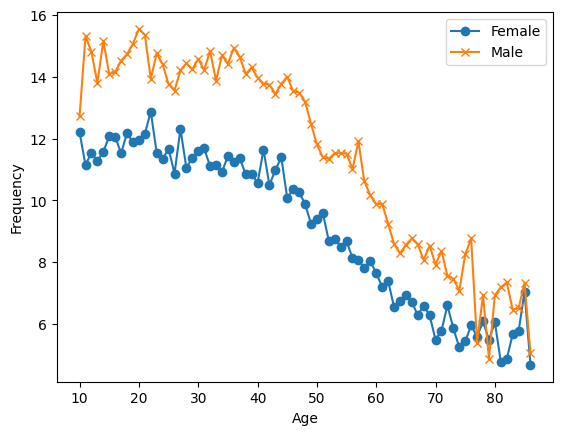

In [26]:
# Create figure and axis objects
fig, ax = plt.subplots()

# Plot "Female" vs. "Age" with marker 'o'
ax.plot(lefthanded_data['Age'], lefthanded_data['Female'], marker='o', label='Female')

# Plot "Male" vs. "Age" with marker 'x'
ax.plot(lefthanded_data['Age'], lefthanded_data['Male'], marker='x', label='Male')

# Add a legend
ax.legend()

# Set labels for x and y axes
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')

plt.show()

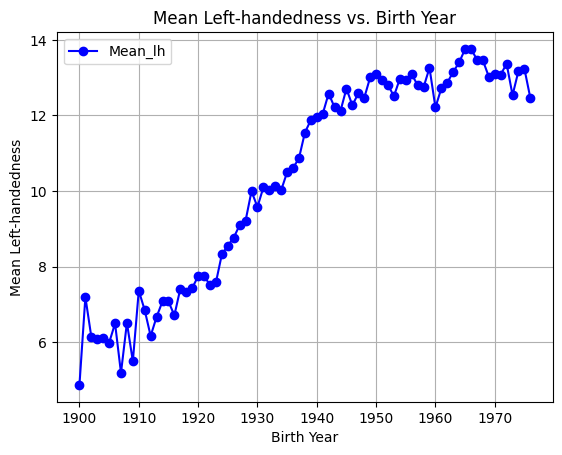

In [27]:
# Create a column for Birth_year
lefthanded_data['Birth_year'] = 1986 - lefthanded_data['Age']

# Create a column for Mean_lh
lefthanded_data['Mean_lh'] = (lefthanded_data['Male'] + lefthanded_data['Female']) / 2

# Plot Mean_lh vs. Birth_year
lefthanded_data.plot(x='Birth_year', y='Mean_lh', marker='o', linestyle='-', color='b')
plt.title('Mean Left-handedness vs. Birth Year')
plt.xlabel('Birth Year')
plt.ylabel('Mean Left-handedness')
plt.grid(True)
plt.show()


In [28]:
lefthanded_data

,Age,Male,Female,Birth_year,Mean_lh
0,10,12.717558,12.198041,1976,12.457800
1,11,15.318830,11.144804,1975,13.231817
2,12,14.808281,11.549240,1974,13.178760
3,13,13.793744,11.276442,1973,12.535093
4,14,15.156304,11.572906,1972,13.364605
...,...,...,...,...,...
72,82,7.350204,4.874899,1904,6.112551
73,83,6.471204,5.672536,1903,6.071870
74,84,6.510858,5.774881,1902,6.142870
75,85,7.337968,7.051459,1901,7.194713


In [83]:
def P_lh_given_A(ages_of_death, study_year=1990):
    early_1900s_rate = lefthanded_data.tail(10)['Mean_lh'].mean() / 100
    late_1900s_rate = lefthanded_data.head(10)['Mean_lh'].mean() / 100
    youngest_age = study_year - 1986 + 10
    oldest_age = study_year - 1986 + 86

    P_return = np.zeros(len(ages_of_death))
    P_return[ages_of_death > oldest_age] = late_1900s_rate
    P_return[ages_of_death < youngest_age] = early_1900s_rate
    middle_mask = np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))

    middle_ages = np.arange(study_year - 1986 + 10, study_year - 1986 + 86 + 1)
    
    # Reindex lefthanded_data to ensure it has a row for every year in middle_ages
    lefthanded_data_reindexed = lefthanded_data.set_index('Birth_year').reindex(middle_ages)
    
    # Interpolate to fill in NaN values
    lefthanded_data_interpolated = lefthanded_data_reindexed.interpolate()
    
    # Now, get middle_rates from the interpolated DataFrame
    middle_rates = lefthanded_data_interpolated['Mean_lh'] / 100

    middle_rates_interp = np.interp(ages_of_death[middle_mask], middle_ages, middle_rates)

    P_return[middle_mask] = middle_rates_interp

    return P_return

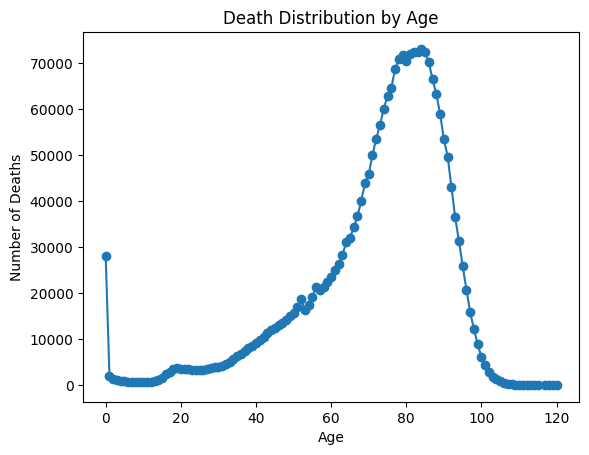

In [86]:
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"
death_distribution_data = pd.read_csv(data_url_2, sep='\t', skiprows=[1])
death_distribution_data.dropna(subset=['Both Sexes'], inplace=True)
fig, ax = plt.subplots()
ax.plot(death_distribution_data['Age'], death_distribution_data['Both Sexes'], marker='o')
ax.set_xlabel('Age')
ax.set_ylabel('Number of Deaths')
plt.title('Death Distribution by Age')
plt.show()

In [85]:
def P_lh(death_distribution_data, study_year=1990):
    p_list = death_distribution_data['Both Sexes'] * P_lh_given_A(death_distribution_data['Age'].values, study_year)
    p = p_list.sum()
    return p / death_distribution_data['Both Sexes'].sum()

print(P_lh(death_distribution_data))

0.015330151139255396


In [87]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year=1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    
    # Calculate P_A, the overall probability of dying at age A
    P_A = death_distribution_data['Both Sexes'] / death_distribution_data['Both Sexes'].sum()
    
    # Calculate P_left, the overall probability of being left-handed
    P_left = P_lh(death_distribution_data, study_year)
    
    # Calculate P_lh_A, the probability of being left-handed given age A
    P_lh_A = P_lh_given_A(ages_of_death, study_year)
    
    return P_lh_A * P_A / P_left

# Example usage:
print(P_A_given_lh(death_distribution_data['Age'].values, death_distribution_data, study_year=1990))


0      0.045784
1      0.003260
2      0.002255
3      0.001714
4      0.001373
         ...   
115    0.000011
117    0.000011
118    0.000004
119    0.000007
120    0.000004
Name: Both Sexes, Length: 120, dtype: float64


In [88]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year=1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    
    # Calculate P_A, the overall probability of dying at each age `ages_of_death`
    P_A = death_distribution_data['Both Sexes'] / death_distribution_data['Both Sexes'].sum()
    
    # Calculate P_right, the overall probability of being right-handed
    P_right = 1 - P_lh(death_distribution_data, study_year)
    
    # Calculate P_rh_A, the probability of being right-handed given each age `ages_of_death`
    P_lh_A = P_lh_given_A(ages_of_death, study_year)
    P_rh_A = 1 - P_lh_A
    
    return P_rh_A * P_A / P_right

# Example usage:
print(P_A_given_rh(death_distribution_data['Age'].values, death_distribution_data, study_year=1990))


0      1.115312e-02
1      7.940567e-04
2      5.493324e-04
3      4.175884e-04
4      3.345498e-04
           ...     
115    1.107414e-06
117    1.107414e-06
118    3.691379e-07
119    7.382758e-07
120    3.691379e-07
Name: Both Sexes, Length: 120, dtype: float64


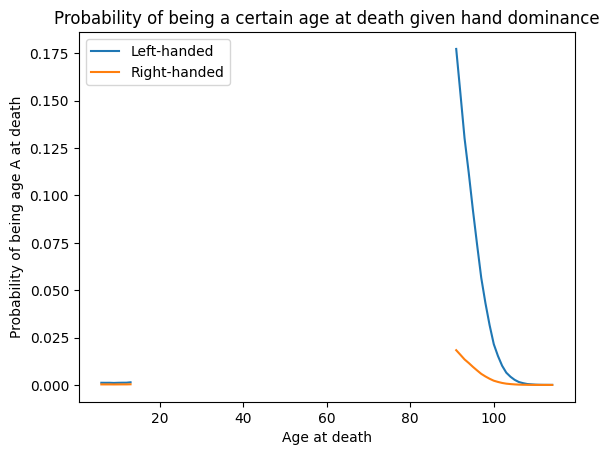

In [95]:
import numpy as np
import matplotlib.pyplot as plt

P_A = death_distribution_data['Both Sexes'][ages_of_death] / death_distribution_data['Both Sexes'].sum()


def P_A_given_lh(ages_of_death, death_distribution_data, study_year=1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / death_distribution_data['Both Sexes'].sum()
    P_left = P_lh(death_distribution_data)  # use P_lh function to get probability of left-handedness overall
    P_lh_A = P_lh_given_A(ages_of_death, study_year)  # use P_lh_given_A to get probability of left-handedness for a certain age
    return P_lh_A * P_A / P_left

def P_A_given_rh(ages_of_death, death_distribution_data, study_year=1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / death_distribution_data['Both Sexes'].sum()
    P_right = 1 - P_lh(death_distribution_data)  # either you're left-handed or right-handed, so P_right = 1 - P_left
    P_rh_A = 1 - P_lh_given_A(ages_of_death, study_year)  # P_rh_A = 1 - P_lh_A 
    return P_rh_A * P_A / P_right

# Calculate the probability of being left- or right-handed for each age
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

# Create a plot of the two probabilities vs. age
fig, ax = plt.subplots()  # Create figure and axis objects
ax.plot(ages, left_handed_probability, label="Left-handed")
ax.plot(ages, right_handed_probability, label="Right-handed")
ax.legend()  # Add a legend
ax.set_xlabel("Age at death")
ax.set_ylabel(r"Probability of being age A at death")
plt.title('Probability of being a certain age at death given hand dominance')
plt.show()


In [96]:
# Calculate average ages for left-handed and right-handed groups
# Use np.array so that two arrays can be multiplied
average_lh_age = np.nansum(ages * np.array(left_handed_probability))
average_rh_age = np.nansum(ages * np.array(right_handed_probability))

# Print the average ages for each group
print("Average age at death for left-handers:", round(average_lh_age, 2))
print("Average age at death for right-handers:", round(average_rh_age, 2))

# Print the difference between the average ages
print("The difference in average ages is " + str(round(average_lh_age - average_rh_age, 2)) + " years.")


Average age at death for left-handers: 88.25
Average age at death for right-handers: 9.13
The difference in average ages is 79.11 years.


In [93]:
# Calculate the probability of being left- or right-handed for all ages in 2018
left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, study_year=2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, study_year=2018)

# Calculate average ages for left-handed and right-handed groups in 2018
average_lh_age_2018 = np.nansum(ages * np.array(left_handed_probability_2018))
average_rh_age_2018 = np.nansum(ages * np.array(right_handed_probability_2018))

print("The difference in average ages is " + 
      str(round(average_rh_age_2018 - average_lh_age_2018, 1)) + " years.")



The difference in average ages is -5.0 years.
